# BentoML Example: Convolutional Autoencoder with PyTorch



[BentoML](http://bentoml.ai) is an open source framework for building, shipping and running machine learning services. It provides high-level APIs for defining an ML service and packaging its artifacts, source code, dependencies, and configurations into a production-system-friendly format that is ready for deployment.

This notebook demonstrates how to use BentoML to turn a PyTorch model into a docker image containing a REST API server serving this model, how to use your ML service built with BentoML as a CLI tool, and how to distribute it a pypi package.

This example was built based on [this notebook](https://github.com/baldassarreFe/zalando-pytorch).

![Impression](https://www.google-analytics.com/collect?v=1&tid=UA-112879361-3&cid=555&t=event&ec=nb&ea=open&el=official-example&dt=pytorch-fashion-mnist)

In [ ]:
!pip install bentoml
!pip install torch torchvision sklearn pillow pandas numpy

In [1]:
%matplotlib inline
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torchvision import transforms
import matplotlib.pyplot as plt
import torchvision
import bentoml

## Prepare Dataset

PyTorch supports FashionMNIST now, so we can import it directly.

In [2]:
from torchvision.datasets import FashionMNIST
FashionMNIST.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [3]:
class MyDataset(Dataset):
    '''
    Build your own dataset
    '''
    def __init__(self, data, transform = None):
        self.fashion_mnist = list(data.values)
        self.transform = transform
        label, img = [],[]
        for one_line in self.fashion_mnist:
            label.append(one_line[0])
            img.append(one_line[1:])
        self.label = np.asarray(label)
        self.img = np.asarray(img).reshape(-1, IMAGE_SIZE, IMAGE_SIZE, CHANNEL).astype('float32')

    def __getitem__(self, item):
        label, img = self.label[item], self.img[item]
        if self.transform is not None:
            img = self.transform(img)

        return label, img

    def __len__(self):
        return len(self.label)

And now load our data and prepare for train

In [4]:
BATCH_SIZE = 50
LR = 0.005
NUM_CLASS = 10
IMAGE_SIZE = 28
CHANNEL = 1
Train_epoch = 1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = FashionMNIST(
    './data', train=True, download=True, 
    transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_dataset = FashionMNIST(
    './data', train=False, download=True, 
    transform=transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

At this time we can show some images in this Dataloader.

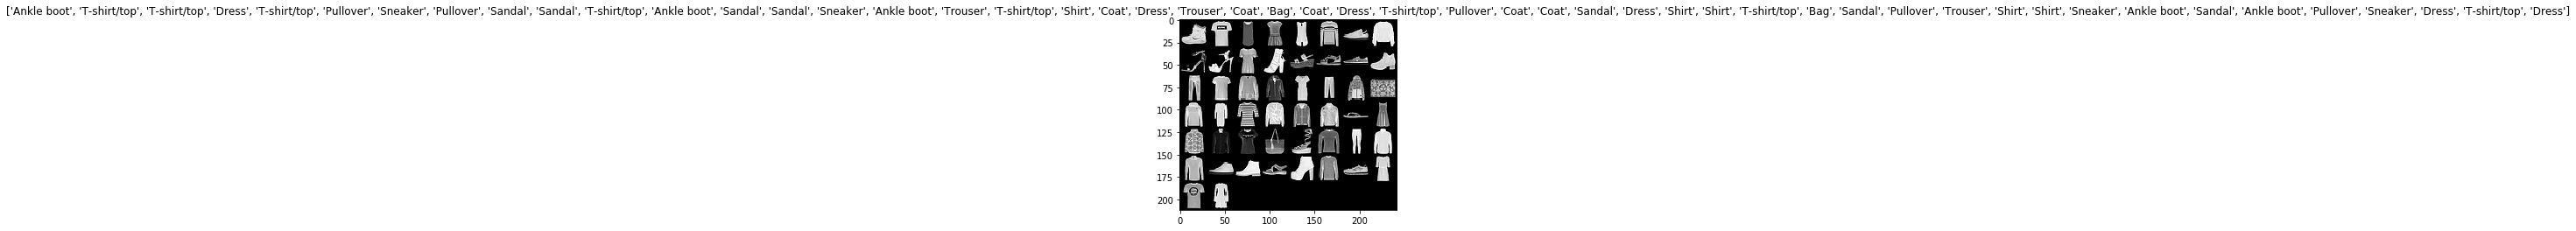

In [6]:
data_iter = iter(train_loader)
img, label = next(data_iter)

def imshow(img, title):
    img = torchvision.utils.make_grid(img)
    img = img.numpy().transpose([1, 2, 0])
    plt.imshow(img)
    if title is not None:
        plt.title(title)

imshow(img, [FashionMNIST.classes[x] for x in label.numpy().tolist()])
plt.show()

## Model Training

Now define our model and train! 

In [7]:
class My_Model(nn.Module):
    def __init__(self, num_of_class):
        super(My_Model, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7 * 7 * 32, num_of_class)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out
    

In [8]:
def train():
    model = My_Model(NUM_CLASS).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = LR)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(1, Train_epoch + 1):
        for batch_id, (image, label) in enumerate(train_loader):
            label, image = label.to(device), image.to(device)
            output = model(image)
            loss = criterion(output, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch_id % 100 == 0:
                print('Loss :{:.4f} Epoch[{}/{}]'.format(loss.item(), epoch, Train_epoch))
    return model

In [9]:
def test(model):
    with torch.no_grad():
        correct = 0
        total = 0
        for image, label in test_loader:
            image = image.to(device)
            label = label.to(device)
            outputs = model(image)
            predicted = torch.argmax(outputs,dim=1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
        print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total))

In [10]:
model = train()
test(model)

Loss :2.3943 Epoch[1/1]
Loss :0.5561 Epoch[1/1]
Loss :0.2779 Epoch[1/1]
Loss :0.2880 Epoch[1/1]
Loss :0.2203 Epoch[1/1]
Loss :0.1618 Epoch[1/1]
Loss :0.2036 Epoch[1/1]
Loss :0.2212 Epoch[1/1]
Loss :0.5353 Epoch[1/1]
Loss :0.3416 Epoch[1/1]
Loss :0.6220 Epoch[1/1]
Loss :0.4945 Epoch[1/1]
Test Accuracy of the model on the test images: 88.49 %


# Define ML service with BentoML

In [11]:
%%writefile pytorch_fashion_mnist.py

import torch
import bentoml
from PIL import Image
from torchvision import transforms

from bentoml.artifact import PytorchModelArtifact
from bentoml.handlers import DataframeHandler
from torch.autograd import Variable
from torchvision.datasets import FashionMNIST

@bentoml.env(conda_dependencies=['torch', 'numpy', 'torchvision', 'scikit-learn'])
@bentoml.artifacts([PytorchModelArtifact('classifier')])
class FashionMNISTModel(bentoml.BentoService):
    """
    documentation strip
    """

    @bentoml.api(DataframeHandler)
    def predict(self, df):
        tensor = torch.tensor(df.values, dtype=torch.uint8)
        img = Image.fromarray(tensor.numpy(), mode='L')
        transform = transforms.Compose([transforms.ToTensor()])
        img = transform(img)

        outputs = self.artifacts.classifier(Variable(img.unsqueeze(0)))
        _, output_classes = outputs.max(dim=1)


        return FashionMNIST.classes[output_classes]

Overwriting pytorch_fashion_mnist.py


# Save BentoML service archive

In [12]:
from pytorch_fashion_mnist import FashionMNISTModel
new_model = FashionMNISTModel.pack(classifier=model)


saved_path = new_model.save('/tmp/bento')
print(saved_path)

[2019-07-18 00:02:45,820] INFO - Searching for dependant modules of pytorch_fashion_mnist:/Users/leon.sun/BentoML/examples/pytorch-fashion-mnist/pytorch_fashion_mnist.py
[2019-07-18 00:02:59,599] INFO - Copying local python module '/Users/leon.sun/BentoML/examples/pytorch-fashion-mnist/pytorch_fashion_mnist.py'
[2019-07-18 00:02:59,601] INFO - Done copying local python dependant modules
[2019-07-18 00:02:59,707] INFO - BentoService FashionMNISTModel:2019_07_18_3b1f96b4 saved to /tmp/bento/FashionMNISTModel/2019_07_18_3b1f96b4
/tmp/bento/FashionMNISTModel/2019_07_18_3b1f96b4


# Load from BentoML service archive

### Run REST API server

In [ ]:
!bentoml serve {saved_path}

 * Serving Flask app "FashionMNISTModel" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on
 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
 * Restarting with stat
 * Debugger is active!
 * Debugger PIN: 193-026-865
127.0.0.1 - - [18/Jul/2019 00:03:14] "POST /predict HTTP/1.1" 200 -


### Call REST API from a client

Run the following command on a command line terminal:

curl -X POST 'http://127.0.0.1:5000/predict' -d '[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 67, 0, 0, 0, 0, 50, 38, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 8, 120, 209, 226, 247, 237, 255, 255, 255, 247, 238, 235, 172, 72, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 137, 239, 252, 243, 234, 229, 238, 244, 246, 240, 230, 232, 239, 248, 251, 194, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 102, 255, 231, 228, 227, 228, 233, 230, 230, 229, 228, 232, 232, 231, 227, 224, 252, 179, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 233, 241, 229, 231, 255, 255, 238, 231, 227, 238, 246, 228, 230, 227, 234, 235, 229, 241, 20, 0, 0, 0, 0], [0, 0, 0, 0, 0, 248, 241, 231, 255, 149, 47, 252, 228, 255, 242, 216, 238, 232, 255, 228, 220, 234, 250, 54, 0, 0, 0, 0], [0, 0, 0, 0, 0, 255, 240, 232, 255, 15, 0, 255, 237, 191, 0, 0, 214, 255, 13, 123, 255, 234, 252, 114, 0, 0, 0, 0], [0, 0, 0, 0, 6, 255, 238, 239, 255, 177, 0, 255, 255, 0, 130, 116, 47, 65, 43, 37, 255, 236, 249, 162, 0, 0, 0, 0], [0, 0, 0, 0, 32, 255, 236, 245, 255, 204, 0, 255, 84, 0, 37, 28, 31, 0, 25, 13, 255, 236, 249, 199, 0, 0, 0, 0], [0, 0, 0, 0, 53, 255, 236, 250, 250, 231, 2, 255, 21, 0, 221, 255, 236, 54, 245, 198, 243, 238, 245, 223, 0, 0, 0, 0], [0, 0, 0, 0, 80, 255, 237, 250, 240, 255, 0, 0, 39, 157, 0, 0, 215, 94, 20, 126, 255, 237, 239, 250, 0, 0, 0, 0], [0, 0, 0, 0, 101, 255, 235, 253, 244, 243, 133, 138, 208, 255, 201, 214, 255, 230, 7, 174, 255, 240, 238, 255, 0, 0, 0, 0], [0, 0, 0, 0, 126, 255, 233, 255, 248, 233, 255, 255, 240, 232, 243, 243, 231, 251, 255, 255, 254, 243, 238, 255, 3, 0, 0, 0], [0, 0, 0, 0, 147, 255, 233, 249, 181, 243, 227, 224, 230, 234, 230, 230, 235, 228, 235, 222, 207, 255, 236, 255, 35, 0, 0, 0], [0, 0, 0, 0, 163, 255, 245, 221, 86, 255, 233, 233, 235, 236, 234, 234, 234, 232, 242, 231, 125, 255, 236, 255, 55, 0, 0, 0], [0, 0, 0, 0, 181, 254, 255, 200, 69, 255, 228, 232, 234, 235, 234, 234, 233, 235, 241, 237, 70, 255, 235, 246, 57, 0, 0, 0], [0, 0, 0, 0, 197, 247, 255, 188, 110, 255, 224, 233, 234, 234, 234, 234, 234, 234, 240, 253, 69, 255, 236, 248, 77, 0, 0, 0], [0, 0, 0, 0, 200, 246, 255, 149, 145, 255, 223, 235, 234, 235, 235, 235, 234, 237, 233, 255, 47, 255, 239, 249, 98, 0, 0, 0], [0, 0, 0, 0, 204, 243, 255, 111, 173, 255, 227, 235, 235, 236, 235, 235, 235, 239, 229, 255, 19, 227, 246, 249, 110, 0, 0, 0], [0, 0, 0, 0, 196, 240, 255, 109, 213, 250, 229, 235, 235, 236, 235, 237, 236, 237, 226, 255, 55, 203, 251, 245, 120, 0, 0, 0], [0, 0, 0, 0, 192, 243, 255, 114, 232, 240, 232, 235, 235, 236, 234, 237, 236, 235, 229, 255, 134, 171, 252, 244, 137, 0, 0, 0], [0, 0, 0, 0, 189, 251, 255, 154, 238, 233, 236, 234, 235, 236, 235, 238, 236, 235, 232, 255, 166, 125, 255, 243, 142, 0, 0, 0], [0, 0, 0, 0, 183, 252, 255, 171, 247, 232, 234, 234, 233, 233, 232, 234, 233, 234, 233, 240, 223, 128, 255, 242, 151, 0, 0, 0], [0, 0, 0, 0, 178, 243, 255, 57, 238, 241, 238, 238, 238, 237, 236, 237, 237, 240, 237, 254, 176, 52, 255, 239, 157, 0, 0, 0], [0, 0, 0, 0, 188, 240, 250, 62, 218, 255, 220, 222, 222, 222, 223, 223, 224, 222, 218, 255, 154, 32, 255, 236, 188, 0, 0, 0], [0, 0, 0, 0, 130, 245, 242, 24, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 34, 242, 244, 135, 0, 0, 0], [0, 0, 0, 0, 76, 255, 249, 22, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 39, 249, 255, 123, 0, 0, 0], [0, 0, 0, 0, 49, 205, 197, 11, 0, 4, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 0, 3, 174, 189, 67, 0, 0, 0]]' -H 'Content-Type: application/json'

You will see the predication result of your model.

# Run REST API server with Docker (Optional)

** _Note: `docker` is not available when running in Google Colaboratory_

In [ ]:
!cd {saved_path} && docker build . -t pytorch-fashion-mnist

In [ ]:
!docker run -p 5000:5000 pytorch-fashion-mnist